In [1]:
#############load necessary libraries##############
# %env MY_ENV_VAR="~/.conda/envs/scenic_protocol/:~/.local/bin/"

import os
# os.environ["MY_ENV_VAR"]
os.environ["MKL_NUM_THREADS"] = "30"
os.environ["NUMEXPR_NUM_THREADS"] = "30"
os.environ["OMP_NUM_THREADS"] = "30"


import os, glob, re, pickle
import scanpy as sc
import pandas as pd
import numpy as np
import scanpy.external as sce
import re
from sklearn.metrics import pairwise_distances
import seaborn as sns
import matplotlib.pyplot as pl
import matplotlib.colors as colors
import operator as op
import anndata as ad
import loompy as lp
#import celloracle as co
import pyarrow
import matplotlib as plt



from functools import partial
from collections import OrderedDict
from cytoolz import compose
from pyscenic.export import export2loom, add_scenic_metadata
from pyscenic.utils import load_motifs
from pyscenic.transform import df2regulons
from pyscenic.aucell import aucell
from pyscenic.binarization import binarize
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_binarization, plot_rss

from IPython.display import HTML, display



%matplotlib inline
import matplotlib as plt

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
sc.set_figure_params(dpi = 150, dpi_save = 150, format = 'png')
sc._settings.ScanpyConfig(verbosity=0)


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

np.random.seed(44)

In [2]:
#############define necessary functions##############

def Get_genes_to_keep(loaded_obj):
    detected_genes = loaded_obj[:,sc.pp.filter_genes(loaded_obj, min_cells=3, 
                                                     inplace=False)[0]].var_names.tolist()
    MitoRiboGenes = (list(filter(lambda x: re.search(r'^Mt-', x, re.IGNORECASE), detected_genes)) + 
                     list(filter(lambda x: re.search(r'^Mtrnr', x, re.IGNORECASE), detected_genes)) + 
                     list(filter(lambda x: re.search(r'^Rpl', x, re.IGNORECASE), detected_genes)) +
                     # "^RP[0-5][0-9]" catches a lot of non ribosomal proteins like LINCs, Pseudogenes and even prot coding genes
                     #list(filter(lambda x: re.search(r'^RP[0-5][0-9]', x, re.IGNORECASE), detected_genes)) +
                     list(filter(lambda x: re.search(r'^Rps', x, re.IGNORECASE), detected_genes)))
    return(list(set(detected_genes) - set(MitoRiboGenes)))


def PreProcessing(obj, QCplots=False, Verbosity="high"):
    obj = obj
  
    if QCplots:
        sc.pl.violin(obj, ['percent_mito', 'percent_ribo', 'n_counts'], jitter=0.4, multi_panel=True)

    # first round of gene filtering
    Genes_to_keep = Get_genes_to_keep(obj)
    obj = obj[:,Genes_to_keep]
    if Verbosity=="high":
        print("First gene filtering: "+str(obj.X.shape))

    # Cells filtering
    sc.pp.filter_cells(obj, min_genes=200)
    median_genes_per_cell = np.median(obj.X.getnnz(axis=1)) # recomputing this per each dataset will introduce inconsistent thrholds
    sc.pp.filter_cells(obj, max_genes=2.5*median_genes_per_cell)
    if Verbosity=="high":
        print("Cell filtering: "+str(obj.X.shape))

    # Second round of gene filtering: some genes got to all-zeros after cell filtering
    Genes_to_keep_2 = Get_genes_to_keep(obj)
    obj = obj[:,Genes_to_keep_2]
    if Verbosity=="high":
        print("Second gene filtering: "+str(obj.X.shape))

    obj = obj
    if QCplots:
        sc.pl.violin(obj, ['percent_mito', 'percent_ribo', 
                           'n_counts', 'n_genes'], jitter=0.4, multi_panel=True)

    if Verbosity=="high":
        print("Raw!")
        #print(obj.X[:10,:10])

    sc.pp.normalize_total(obj, layers= None)
    if Verbosity=="high":
        print("Normalized")
        #print(obj.X[:10,:10])

    sc.pp.log1p(obj)
    if Verbosity=="high":
        print("Log transformed")
        #print(obj.X[:10,:10])

    sc.pp.highly_variable_genes(obj) # needs log transformed data
    if QCplots:
        sc.pl.highly_variable_genes(obj)
    #if Verbosity=="high":
        #print("HVG subset: "+str(obj.shape))
    
    return(obj)


# PROVIDE CELL CYCLE GENE LISTS FOR PHASE SCORING
S_genes_file = "/home/kgr851/new_analysis_new_cc/cc/s.txt"
G2M_genes_file = "/home/kgr851/new_analysis_new_cc/cc/g2m.txt"
S_phase_genes = [x.strip() for x in open(S_genes_file)]
G2M_phase_genes = [x.strip() for x in open(S_genes_file)]

def CellCycleRegression(obj):
    
    # N.B. Regression is only performed on matrix .X
    
        print("Regressing individual phases")
        sc.pp.scale(obj)
        sc.tl.score_genes_cell_cycle(obj, s_genes=S_phase_genes, g2m_genes=G2M_phase_genes)
        sc.pp.regress_out(obj, ['S_score', 'G2M_score'])
        sc.pp.scale(obj)
        # Store "old_phase" for later plotting of regression effect on phase%
        obj.obs['OldPhase'] = obj.obs['phase']
        sc.tl.score_genes_cell_cycle(obj, s_genes=S_phase_genes, g2m_genes=G2M_phase_genes)
        print("Regressed")
        print(obj.X[:10,:10])
   
        return(obj)

def subset_two_genes2(adata, gene1: str ,gene2: str, coexpressed: bool = False):
    gene1_cells = adata[adata[: , gene1].X > 0.8, :].obs_names
    gene2_cells = adata[adata[: , gene2].X > 0.8, :].obs_names
    
    if coexpressed:
        cells = np.intersect1d(gene1_cells, gene2_cells)
    else:
         cells = np.unique(np.concatenate([gene1_cells, gene2_cells]))
    
    return adata[cells, ].copy()

# def subset_two_genes(adata, gene1: str ,gene2: str):
#     x = adata[adata[: , gene1].X > 0.75, :]
#     y = adata[adata[: , gene2].X > 0.75, :]
#     common_obs = np.intersect1d(x.obs_names, y.obs_names)
#     mix = adata[common_obs]
#     x = x[~x.obs_names.isin(common_obs)].copy()
#     y = y[~y.obs_names.isin(common_obs)].copy()
    
# print('subset data is ready')
    
# subset = mix.concatenate(x,y, batch_key = False)
    
# return subset
    

# def subset_two_genes2(adata, gene1: str ,gene2: str, coexpressed: bool = False):
    
#     value1 = np.mean(adata[:, gene1].X.toarray().flatten())+np.std(adata[:, gene1].X.toarray().flatten())
#     value2 = np.mean(adata[:, gene2].X.toarray().flatten())+np.std(adata[:, gene2].X.toarray().flatten())
    
#     gene1_cells = adata[adata[: , gene1].X > value1, :].obs_names
#     gene2_cells = adata[adata[: , gene2].X > value2, :].obs_names
    
#     if coexpressed:
#         cells = np.intersect1d(gene1_cells, gene2_cells)
#     else:
#         cells = np.unique(np.concatenate([gene1_cells, gene2_cells]))
    
#     return adata[cells, ].copy()

# load adata for day 5 to 14 cells expressing FOXA2 or NKx2-1 

In [3]:
all_mistr_nf = sc.read_h5ad('mistr_day5-14_nf.h5ad')

in this condtiton we would like to analyse
lineages of telencephalon and diencephalon 
therefore we take OTX2+ cells only 

In [5]:
###### subset OTX2+ cells only######
all_mistr_nf_otx2 = all_mistr_nf[all_mistr_nf[: , 'OTX2'].X > 0, :]

In [6]:
all_mistr_nf_otx2

View of AnnData object with n_obs × n_vars = 5156 × 21923
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.4', 'seurat_clusters', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'annotations', 'Subclass', 'day', 'Age', 'SCT_snn_res.0.6', 'batch', 'n_genes', 'cluster', 'dpt_pseudotime'
    var: 'highly_variable', 'gene_ids', 'feature_types', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cluster_colors', 'day_colors', 'diffmap_evals', 'draw_graph', 'hvg', 'iroot', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'counts', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

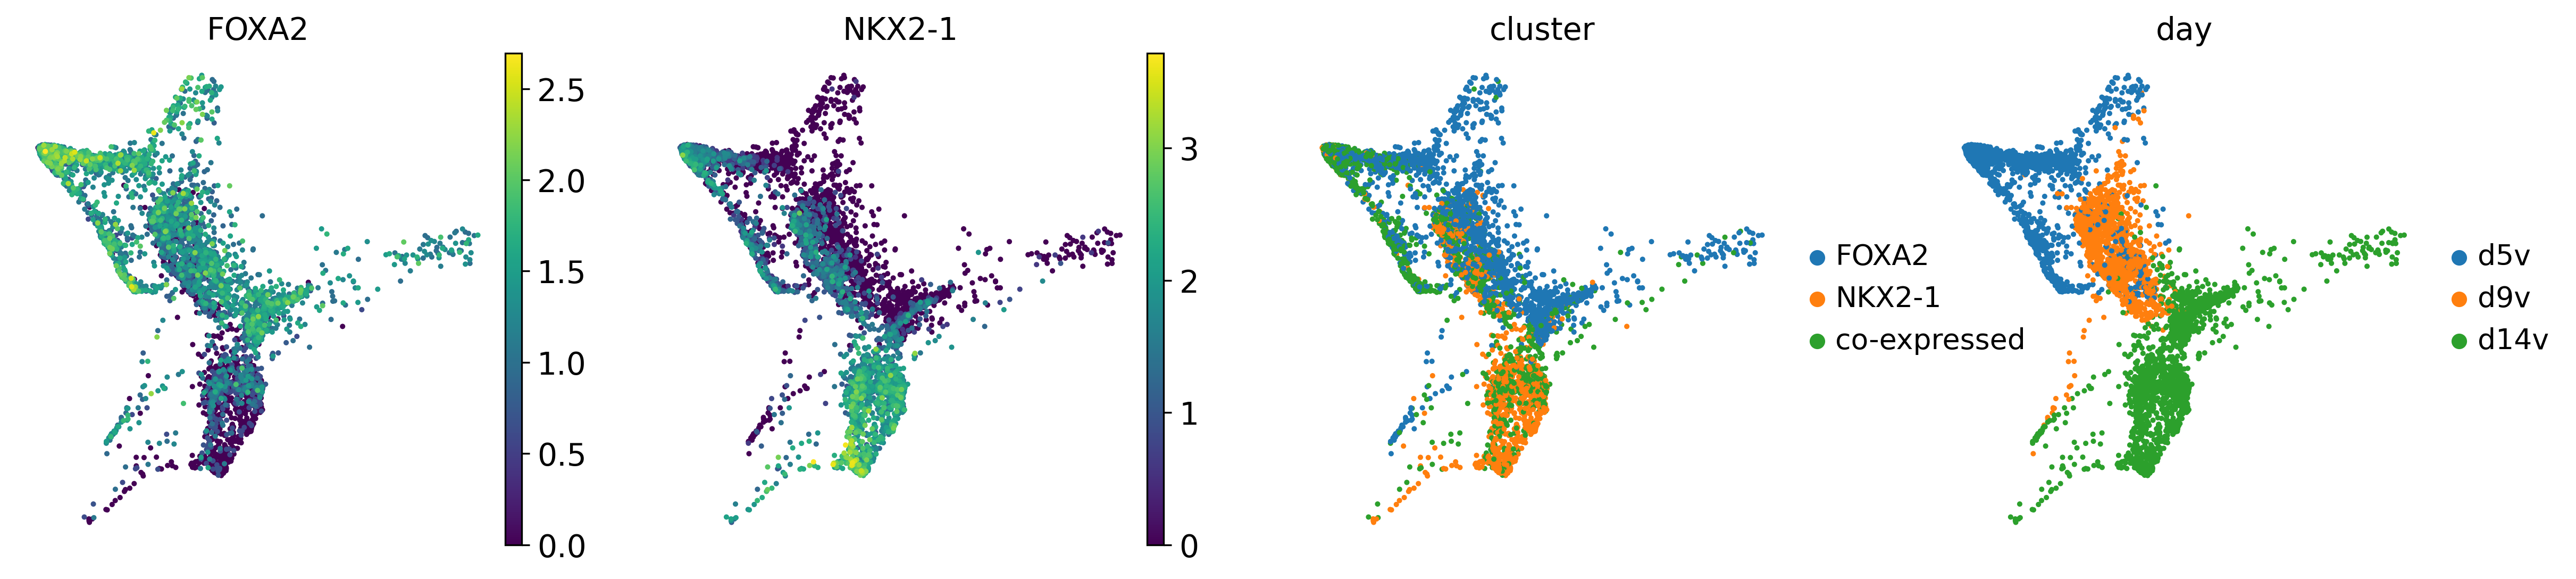

In [7]:
sc.pl.draw_graph(all_mistr_nf_otx2, color=['FOXA2','NKX2-1','cluster',"day"],frameon=False)

In [ ]:
scv.pl.draw_graph(adata, color=['cluster'],frameon=False,save = "NKX_FOXA2_subset_OTX2_cells.svg" ,vmax = 4, sort_order= False, dpi = 300)


## time for enrichment of TF and targets###

In [8]:
# set variables for file paths to read from and write to:

# set a working directory
wdir = "/home/kgr851/python/mistr_atlas/figures/test"
os.chdir( wdir )

# # path to loom file with basic filtering applied (this will be created in the "initial filtering" step below). Optional.
f_loom_path_scenic = "nkx_mistr_filtered_scenic.loom"

f_matrix_path_scenic = 'exp_matrix.csv'

# path to anndata object, which will be updated to store Scanpy results as they are generated below
f_anndata_path = "nkx_mistr.h5ad"

# path to pyscenic output
f_pyscenic_output = "nkx_mistr_pyscenic_output.loom"

# loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = 'nkx_mistr_scenic_integrated-output.loom'

In [9]:
##### create a copy of original adata 
adata_original = all_mistr_nf_otx2.copy()

# first we do scenic and the we proceed to cell oracle ######
## scenic analysis starts now 

In [10]:
adata_scenic  = all_mistr_nf_otx2.copy()
adata_scenic.X = adata_scenic.layers['counts'].copy()

### select top 2000 hvg for analysis #####
sc.pp.highly_variable_genes(
    adata_scenic,
    flavor="seurat_v3",
    n_top_genes=2_000,
    subset=True
)

In [11]:
sc.pp.normalize_total(adata_scenic)
sc.pp.log1p(adata_scenic)

In [13]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata_scenic.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata_scenic.obs_names) ,
    "nGene": np.array( np.sum(adata_scenic.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata_scenic.X.transpose() , axis=0)).flatten() ,
}
lp.create( f_loom_path_scenic, adata_scenic.X.transpose(), row_attrs, col_attrs)

## scenic step 1 GRN inference using Grnboost2 

In [14]:
## start scenic analysis 
f_tfs = "/home/kgr851/python/scenic/database/hg-tflist/hs_hgnc_tfs.txt" # human


In [15]:
adata_scenic.to_df().to_csv('exp_matrix.csv')

. start CLI for grn boost

In [16]:
!pyscenic grn {f_loom_path_scenic} {f_tfs} -m grnboost2 -o adj.csv   --num_workers 10


2023-04-08 22:36:43,422 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2023-04-08 22:36:43,584 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.
/home/kgr851/.local/lib/python3.7/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46510 instead
  f"Port {expected} is already in use.\n"
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: At

In [17]:
######### read the adj file and look for TF targets
######### select target above mean expression of importance 
adjacencies = pd.read_csv("adj.csv", index_col=False)
value = np.quantile(adjacencies['importance'].copy(), q = 0.99)
adj2 = adjacencies.copy()
adj2 = adjacencies[adjacencies['importance']>= value]
adj2

,TF,target,importance
0,ENO1,TPI1,395.582936
1,TPI1,ENO1,315.539140
2,ENO1,LDHA,260.213063
3,HMGB2,PTTG1,242.961164
4,HSPA5,CALR,225.739813
...,...,...,...
2875,FEZF2,CRNDE,25.940020
2876,RFX4,EFCC1,25.935037
2877,FEZF2,MAB21L2,25.927074
2878,KIF22,RHNO1,25.925968


##  Regulon prediction aka cisTarget from CLI

In [18]:
import glob
# ranking databases
f_db_glob = "/home/kgr851/python/scenic/database/cisTarget_databases/hg38/*feather"
f_db_names = ' '.join( glob.glob(f_db_glob) )

# motif databases
f_motif_path = "/home/kgr851/python/scenic/database/hg-anno/motifs-v9-nr.hgnc-m0.001-o0.0.tsv"

In [19]:
!pyscenic ctx adj.csv \
     {f_db_names} \
     --annotations_fname {f_motif_path} \
     --expression_mtx_fname {f_loom_path_scenic} \
     --output reg.csv \
     --mask_dropouts \
     --num_workers 10


2023-04-08 22:45:06,572 - pyscenic.cli.pyscenic - INFO - Creating modules.

2023-04-08 22:45:06,665 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2023-04-08 22:45:06,873 - pyscenic.utils - INFO - Calculating Pearson correlations.

2023-04-08 22:45:06,915 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [True].

2023-04-08 22:45:08,454 - pyscenic.utils - INFO - Creating modules.

2023-04-08 22:45:15,709 - pyscenic.cli.pyscenic - IN

In [20]:
nGenesDetectedPerCell = np.sum(adata_scenic.X>0, axis=1)
percentiles = np.percentile(nGenesDetectedPerCell,[10,50, 75, 100])
print(percentiles)

[310. 398. 473. 640.]


In [21]:
nGenesDetectedPerCellbefore = np.sum(adata_scenic.X.toarray() >0, axis=1)
nGenesDetectedPerCell = pd.Series(nGenesDetectedPerCellbefore)
percentiles = nGenesDetectedPerCell.quantile([0.01, 0.05, 0.10, 0.50, 1])
percentiles

0.01    244.0
0.05    278.0
0.10    310.0
0.50    398.0
1.00    640.0
dtype: float64

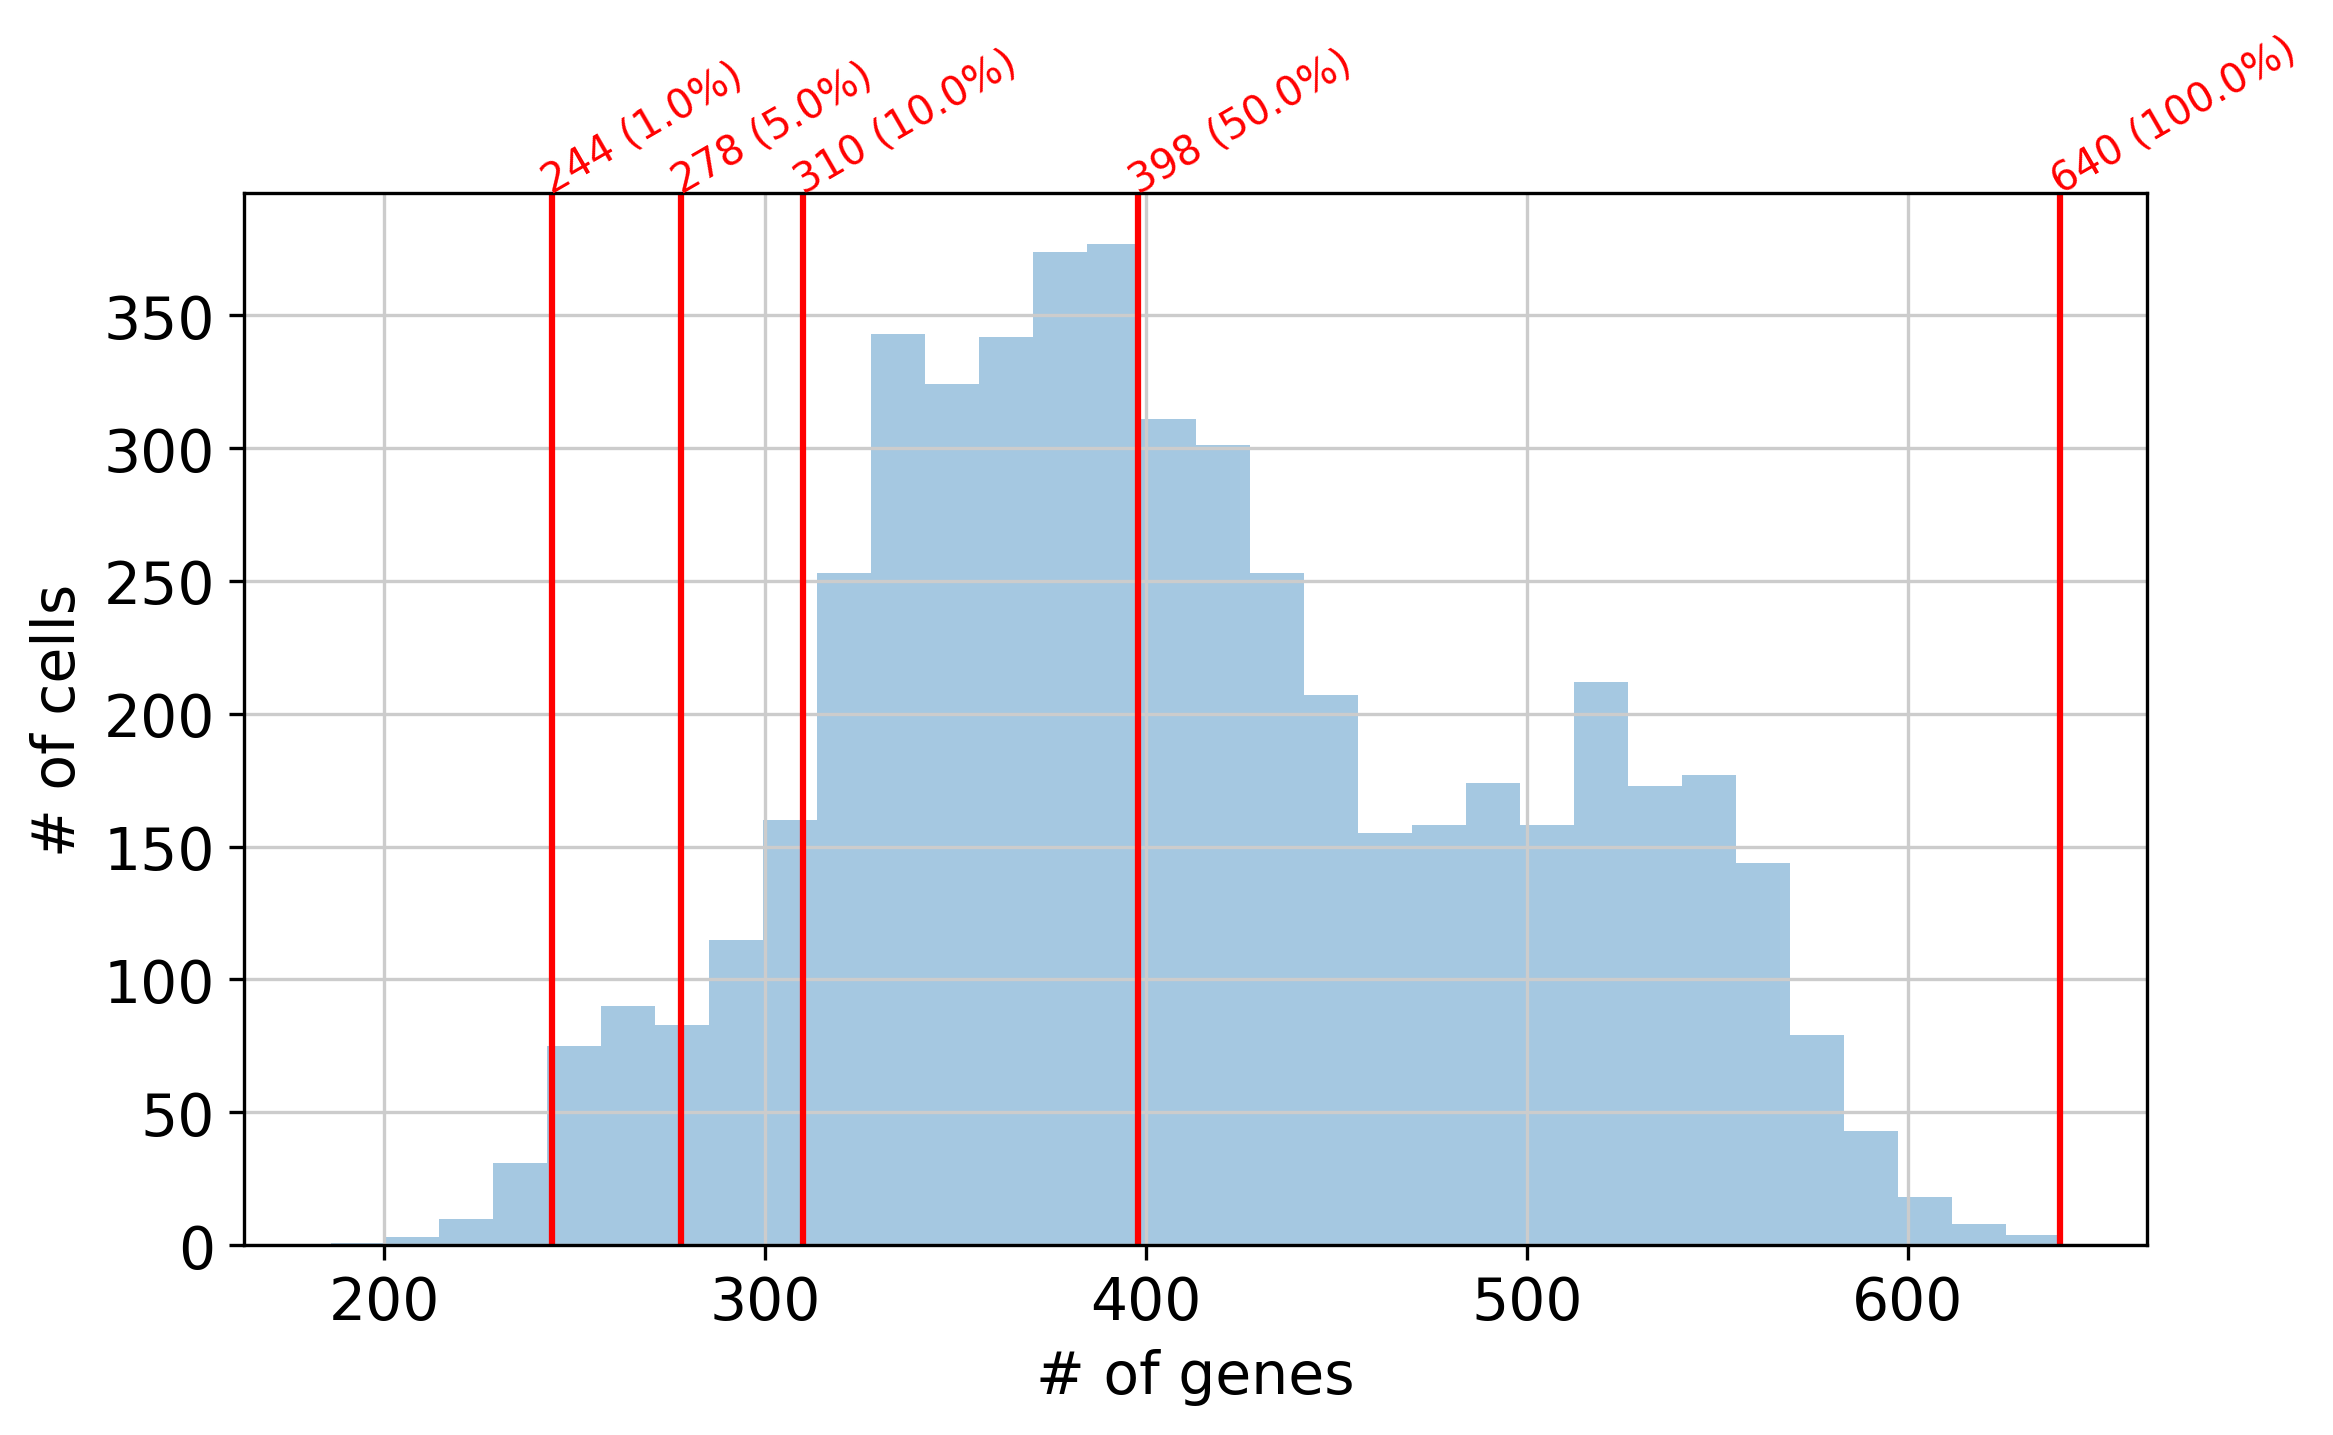

In [22]:
fig, ax = plt.pyplot.subplots(1, 1, figsize=(8, 5), dpi=150)
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0,ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({percentiles.index.values[i]*100}%)', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

In [23]:
df_motifs = load_motifs('reg.csv')

In [24]:
BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
COLUMN_NAME_LOGO = "MotifLogo"
COLUMN_NAME_MOTIF_ID = "MotifID"
COLUMN_NAME_TARGETS = "TargetGenes"


def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
    """
    :param df:
    :param base_url:
    """
    # Make sure the original dataframe is not altered.
    df = df.copy()
    
    # Add column with URLs to sequence logo.
    def create_url(motif_id):
        return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
    df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
    # Truncate TargetGenes.
    def truncate(col_val):
        return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
    df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
    MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', -1)
    display(HTML(df.head().to_html(escape=False)))
    pd.set_option('display.max_colwidth', MAX_COL_WIDTH)
    
display_logos(df_motifs.head())

In [25]:
def derive_regulons(motifs, db_names=('	hg38__refseq-r80__10kb_up_and_down_tss.mc9nr', 
                                 'hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr')):
    motifs.columns = motifs.columns.droplevel(0)

    def contains(*elems):
        def f(context):
            return any(elem in context for elem in elems)
        return f

    # For the creation of regulons we only keep the 10-species databases and the activating modules. We also remove the
    # enriched motifs for the modules that were created using the method 'weight>50.0%' (because these modules are not part
    # of the default settings of modules_from_adjacencies anymore.
    motifs = motifs[
        np.fromiter(map(compose(op.not_, contains('weight>50.0%')), motifs.Context), dtype=np.bool) & \
        np.fromiter(map(contains(*db_names), motifs.Context), dtype=np.bool) & \
        np.fromiter(map(contains('activating'), motifs.Context), dtype=np.bool)]

    # We build regulons only using enriched motifs with a NES of 3.0 or higher; we take only directly annotated TFs or TF annotated
    # for an orthologous gene into account; and we only keep regulons with at least 10 genes.
    regulons = list(filter(lambda r: len(r) >= 10, df2regulons(motifs[(motifs['NES'] >= 3.0) 
                                                                      & ((motifs['Annotation'] == 'gene is directly annotated')
                                                                        | (motifs['Annotation'].str.startswith('gene is orthologous to')
                                                                           & motifs['Annotation'].str.endswith('which is directly annotated for motif')))
                                                                     ])))
    
    # Rename regulons, i.e. remove suffix.
    return list(map(lambda r: r.rename(r.transcription_factor), regulons))

In [26]:
regulons = derive_regulons(df_motifs)

Create regulons from a dataframe of enriched features.
Additional columns saved: []


/home/kgr851/.local/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app
/home/kgr851/.local/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


# AUCELL

In [27]:
# Pickle these regulons.
with open('regulons.dat', 'wb') as f:
    pickle.dump(regulons, f)

In [28]:
!pyscenic aucell \
    {f_loom_path_scenic} \
    reg.csv \
    --output {'aucell.csv'} \
    --auc_threshold 0.10 \
    --num_workers 10


2023-04-08 22:56:13,311 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2023-04-08 22:56:13,472 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.
Create regulons from a dataframe of enriched features.
Additional columns saved: []

2023-04-08 22:56:17,365 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.

2023-04-08 22:56:21,168 - pyscenic.cli.pyscenic - INFO - Writing results to file.


In [29]:
regulons

[Regulon(name='ATF3', gene2weight=frozendict.frozendict({'CREB5': 19.382603209517164, 'VEGFA': 14.265939943061364, 'FOSB': 2.018723736918693, 'DUSP1': 10.53939019461614, 'MAP1LC3A': 2.481135244496955, 'TRIB3': 19.62363535292701, 'JUN': 32.340660471414324, 'LBH': 10.490243927040703, 'SLC3A2': 35.92038845541662, 'ATF3': 1.0, 'CAMK2N2': 2.314089997732479, 'DUSP8': 19.520923045165627, 'SPAG4': 1.1023923661397812, 'HERPUD1': 31.64125652610277, 'TCEAL7': 3.398805980608949, 'KLF6': 12.16167655146727, 'JUND': 28.65509299235656, 'HRK': 3.9071802473935673, 'TAGLN2': 14.100917399196948, 'ID4': 1.9579984593965176, 'CHAC1': 18.22676007801167, 'FOXP2': 5.3297091409706, 'PPP1R15A': 20.592752314189127, 'DDIT3': 36.713054598223614, 'SLC7A11': 8.54575719302592, 'BTG2': 1.6375352642468937, 'STMN4': 3.9670409333045353, 'SPINT1': 2.269505044478976, 'SPAG6': 3.1216942417615003, 'CYP51A1': 1.1143517017223823, 'DTNA': 1.190513193318914, 'PTPRN': 9.12306524498944, 'KCNMA1': 4.005275844922977, 'CXXC5': 6.588678

In [30]:
auc_mtx = pd.read_csv('aucell.csv', index_col=0)
auc_mtx

,ARX(+),ATF3(+),ATF5(+),BARHL1(+),BARX1(+),BHLHE22(+),BRCA1(+),CEBPB(+),CREB5(+),CTCFL(+),DBX1(+),DDIT3(+),DLX1(+),DLX2(+),DLX5(+),DMBX1(+),DMRTA1(+),DMRTA2(+),E2F1(+),E2F7(+),E2F8(+),EGR1(+),EGR2(+),EGR3(+),EMX1(+),EMX2(+),EN1(+),EN2(+),ETV4(+),ETV5(+),FOS(+),FOSB(+),FOXA1(+),FOXA2(+),FOXB1(+),FOXJ1(+),FOXM1(+),FOXO1(+),FOXP1(+),FOXP2(+),FOXP3(+),GATA2(+),GBX2(+),GSC(+),GSX1(+),HES2(+),HESX1(+),HMGA2(+),HMGB1(+),HMGB2(+),HMGB3(+),HOXA1(+),HOXA2(+),HOXB2(+),HOXB4(+),HOXB8(+),IRX1(+),IRX2(+),IRX5(+),ISL1(+),JDP2(+),JUN(+),JUNB(+),JUND(+),KLF6(+),LEF1(+),LHX1(+),LHX2(+),LHX5(+),LHX9(+),LMX1A(+),MAF(+),MAFB(+),MEF2C(+),MSX1(+),MSX2(+),NEUROD1(+),NEUROG1(+),NEUROG2(+),NFIA(+),NHLH1(+),NKX2-1(+),NKX2-8(+),NKX6-1(+),NKX6-2(+),NR5A1(+),NR5A2(+),NUAK1(+),OLIG2(+),OLIG3(+),ONECUT1(+),ONECUT2(+),ONECUT3(+),OTP(+),OTX1(+),PAX2(+),PAX6(+),PHOX2A(+),PHOX2B(+),PLAGL1(+),POU2F2(+),POU3F1(+),POU3F2(+),POU3F3(+),POU3F4(+),POU5F1(+),PRRX1(+),PRRX2(+),RAD21(+),RAX(+),RUNX2(+),SHOX(+),SHOX2(+),SIX3(+),SIX6(+),SOX1(+),SOX11(+),SOX21(+),SOX3(+),SOX4(+),SOX5(+),SOX6(+),SOX9(+),SP5(+),TAL1(+),TBX3(+),TCF12(+),TCF4(+),TCF7L1(+),TCF7L2(+),TPI1(+),UNCX(+),VAX1(+),VSX1(+),XBP1(+),ZEB1(+),ZIC2(+),ZIC3(+),ZNF471(+)
Cell,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGTAGTCAA-2,0.048947,0.055459,0.093533,0.011486,0.000000,0.0000,0.152430,0.059691,0.074975,0.096250,0.030909,0.076784,0.043625,0.0000,0.06225,0.0080,0.048903,0.108616,0.093726,0.090402,0.103876,0.17050,0.053889,0.052333,0.000000,0.024167,0.063875,0.009167,0.018387,0.012895,0.132966,0.055079,0.037320,0.037661,0.047667,0.007037,0.010789,0.030789,0.027109,0.000000,0.015455,0.000000,0.016195,0.016250,0.000000,0.049,0.059333,0.071865,0.657778,0.223542,0.268571,0.135455,0.049821,0.000000,0.000,0.000000,0.021522,0.066894,0.000000,0.030937,0.085778,0.079929,0.050046,0.104048,0.0850,0.056894,0.000000,0.143074,0.036190,0.1360,0.066911,0.057000,0.000000,0.080915,0.039394,0.033393,0.034583,0.0000,0.032262,0.000000,0.0002,0.162059,0.031250,0.038214,0.052028,0.0950,0.103333,0.000000,0.000000,0.000000,0.023631,0.024717,0.0,0.025513,0.017368,0.019933,0.017021,0.000000,0.131429,0.1405,0.020650,0.068164,0.069583,0.017500,0.059032,0.050839,0.000000,0.042217,0.109151,0.128191,0.117500,0.0,0.065435,0.264722,0.130312,0.053387,0.078063,0.028385,0.061336,0.079955,0.062955,0.0000,0.015312,0.039000,0.025238,0.026154,0.000000,0.036192,0.049912,0.043080,0.093436,0.065672,0.077414,0.1120,0.119783,0.036882,0.051581,0.000000,0.000000
AAACCCAAGTAGTGCG-1,0.081316,0.025301,0.044946,0.014595,0.000000,0.0325,0.077991,0.035965,0.044271,0.042188,0.067273,0.032076,0.048875,0.0000,0.08675,0.0215,0.066173,0.112514,0.052404,0.062105,0.063947,0.06500,0.036667,0.021750,0.025000,0.049167,0.067344,0.123889,0.052903,0.052368,0.096271,0.071905,0.042526,0.051629,0.043333,0.000000,0.093684,0.070175,0.035078,0.000000,0.033636,0.020938,0.032257,0.000000,0.010000,0.000,0.052667,0.076803,0.611111,0.200521,0.357143,0.118864,0.100357,0.000000,0.155,0.047778,0.056304,0.064129,0.042500,0.030781,0.044037,0.050690,0.032215,0.068407,0.0908,0.053584,0.016444,0.085875,0.088571,0.0650,0.085524,0.095000,0.000000,0.050106,0.045985,0.059107,0.063241,0.0000,0.027917,0.000000,0.0179,0.018824,0.052083,0.052262,0.049476,0.1065,0.000000,0.021667,0.000000,0.000000,0.029464,0.047736,0.0,0.038077,0.077500,0.056133,0.030851,0.002895,0.129048,0.1575,0.027236,0.062525,0.096389,0.042910,0.055323,0.045290,0.000000,0.059717,0.177821,0.097660,0.000000,0.0,0.069348,0.138889,0.000000,0.038710,0.154875,0.099923,0.084962,0.136577,0.105606,0.0052,0.000000,0.014333,0.035476,0.094615,0.000000,0.053852,0.059499,0.059902,0.084739,0.072761,0.008276,0.1068,0.093261,0.045294,0.092000,0.121176,0.076429
AAACCCACATCCGTTC-2,0.169211,0.048323,0.054022,0.030405,0.016875,0.0115,0.141916,0.040618,0.069623,0.046250,0.024545,0.047778,0.022500,0.0000,0.07275,0.0575,0.061505,0.152401,0.068570,0.081108

## now lets add scenic info to adata 

In [31]:
add_scenic_metadata(adata_scenic, auc_mtx, regulons)

AnnData object with n_obs × n_vars = 5156 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.4', 'seurat_clusters', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'annotations', 'Subclass', 'day', 'Age', 'SCT_snn_res.0.6', 'batch', 'n_genes', 'cluster', 'dpt_pseudotime', 'Regulon(ARX(+))', 'Regulon(ATF3(+))', 'Regulon(ATF5(+))', 'Regulon(BARHL1(+))', 'Regulon(BARX1(+))', 'Regulon(BHLHE22(+))', 'Regulon(BRCA1(+))', 'Regulon(CEBPB(+))', 'Regulon(CREB5(+))', 'Regulon(CTCFL(+))', 'Regulon(DBX1(+))', 'Regulon(DDIT3(+))', 'Regulon(DLX1(+))', 'Regulon(DLX2(+))', 'Regulon(DLX5(+))', 'Regulon(DMBX1(+))', 'Regulon(DMRTA1(+))', 'Regulon(DMRTA2(+))', 'Regulon(E2F1(+))', 'Regulon(E2F7(+))', 'Regulon(E2F8(+))', 'Regulon(EGR1(+))', 'Regulon(EGR2(+))'

In [32]:
rss_cluster = regulon_specificity_scores( auc_mtx, adata_scenic.obs.cluster )
rss_cluster

,ARX(+),ATF3(+),ATF5(+),BARHL1(+),BARX1(+),BHLHE22(+),BRCA1(+),CEBPB(+),CREB5(+),CTCFL(+),DBX1(+),DDIT3(+),DLX1(+),DLX2(+),DLX5(+),DMBX1(+),DMRTA1(+),DMRTA2(+),E2F1(+),E2F7(+),E2F8(+),EGR1(+),EGR2(+),EGR3(+),EMX1(+),EMX2(+),EN1(+),EN2(+),ETV4(+),ETV5(+),FOS(+),FOSB(+),FOXA1(+),FOXA2(+),FOXB1(+),FOXJ1(+),FOXM1(+),FOXO1(+),FOXP1(+),FOXP2(+),FOXP3(+),GATA2(+),GBX2(+),GSC(+),GSX1(+),HES2(+),HESX1(+),HMGA2(+),HMGB1(+),HMGB2(+),HMGB3(+),HOXA1(+),HOXA2(+),HOXB2(+),HOXB4(+),HOXB8(+),IRX1(+),IRX2(+),IRX5(+),ISL1(+),JDP2(+),JUN(+),JUNB(+),JUND(+),KLF6(+),LEF1(+),LHX1(+),LHX2(+),LHX5(+),LHX9(+),LMX1A(+),MAF(+),MAFB(+),MEF2C(+),MSX1(+),MSX2(+),NEUROD1(+),NEUROG1(+),NEUROG2(+),NFIA(+),NHLH1(+),NKX2-1(+),NKX2-8(+),NKX6-1(+),NKX6-2(+),NR5A1(+),NR5A2(+),NUAK1(+),OLIG2(+),OLIG3(+),ONECUT1(+),ONECUT2(+),ONECUT3(+),OTP(+),OTX1(+),PAX2(+),PAX6(+),PHOX2A(+),PHOX2B(+),PLAGL1(+),POU2F2(+),POU3F1(+),POU3F2(+),POU3F3(+),POU3F4(+),POU5F1(+),PRRX1(+),PRRX2(+),RAD21(+),RAX(+),RUNX2(+),SHOX(+),SHOX2(+),SIX3(+),SIX6(+),SOX1(+),SOX11(+),SOX21(+),SOX3(+),SOX4(+),SOX5(+),SOX6(+),SOX9(+),SP5(+),TAL1(+),TBX3(+),TCF12(+),TCF4(+),TCF7L1(+),TCF7L2(+),TPI1(+),UNCX(+),VAX1(+),VSX1(+),XBP1(+),ZEB1(+),ZIC2(+),ZIC3(+),ZNF471(+)
NKX2-1,0.332758,0.372726,0.365066,0.339165,0.214574,0.284858,0.375403,0.369373,0.381553,0.394166,0.348777,0.376269,0.384012,0.296757,0.371164,0.357078,0.364961,0.368067,0.383200,0.372873,0.374958,0.361789,0.268413,0.335197,0.251297,0.337824,0.361022,0.313704,0.359855,0.370334,0.364441,0.362630,0.341654,0.340323,0.299966,0.308485,0.325529,0.346116,0.340942,0.221591,0.328910,0.353812,0.349247,0.290268,0.299610,0.232942,0.394022,0.363677,0.372786,0.376745,0.372673,0.363524,0.342466,0.176836,0.258719,0.242971,0.325828,0.365858,0.262617,0.410528,0.381046,0.376440,0.366268,0.381661,0.360497,0.366985,0.338360,0.379642,0.351338,0.405314,0.361265,0.341756,0.201349,0.385075,0.361452,0.349048,0.365986,0.267629,0.367542,0.254003,0.322857,0.453766,0.303401,0.336760,0.358092,0.378031,0.259173,0.277367,0.260739,0.299924,0.381178,0.365376,0.200854,0.383806,0.357519,0.333115,0.353482,0.306886,0.386527,0.327392,0.375434,0.383426,0.370423,0.359799,0.369223,0.347333,0.348421,0.364992,0.364920,0.420181,0.338012,0.218799,0.367823,0.431119,0.449961,0.376364,0.348257,0.349473,0.381414,0.347716,0.356965,0.319095,0.408747,0.367341,0.319451,0.346995,0.300244,0.344363,0.344272,0.353944,0.380078,0.370670,0.408691,0.384478,0.370061,0.368314,0.352317,0.312366,0.284184
FOXA2,0.514900,0.505605,0.497204,0.488326,0.276746,0.266645,0.483848,0.500254,0.490242,0.392547,0.321564,0.493262,0.445350,0.343873,0.489898,0.400906,0.505516,0.503513,0.484279,0.494257,0.481813,0.467823,0.354953,0.454628,0.257733,0.521910,0.499894,0.384380,0.466220,0.422351,0.500275,0.504750,0.515470,0.510148,0.520739,0.511769,0.401043,0.480021,0.508904,0.296520,0.364523,0.431392,0.515281,0.331582,0.463745,0.247498,0.350882,0.495438,0.490409,0.487861,0.485692,0.490305,0.428830,0.208648,0.277200,0.481497,0.531770,0.510359,0.453952,0.365151,0.485307,0.497080,0.501597,0.494069,0.489002,0.499470,0.433834,0.478010,0.487115,0.447444,0.505199,0.472113,0.257487,0.476395,0.506387,0.496530,0.498574,0.382374,0.498104,0.219685,0.409154,0.326808,0.422074,0.505317,0.512852,0.486474,0.253583,0.486099,0.241566,0.342059,0.468354,0.494016,0.206761,0.452325,0.473590,0.507821,0.507828,0.414302,0.458570,0.488113,0.467911,0.488601,0.496025,0.503061,0.498800,0.502015,0.342918,0.490154,0.484527,0.366984,0.398208,0.322783,0.451511,0.340316,0.309559,0.495534,0.498975,0.482854,0.462078,0.497802,0.479483,0.352119,0.442187,0.427252,0.510953,0.356830,0.393162,0.496632,0.502608,0.484397,0.496369,0.499637,0.416501,0.461597,0.496629,0.499659,0.487201,0.518215,0.435317
co-expressed,0.385662,0.412755,0.429225,0.403229,0.220225,0.266864,0.426051,0.423211,0.425869,0.440829,0.402868,0.425315,0.447107,0.349933,0.423454,0.369810,0.427717,0.425852,0.430776,0.432424,0.431019,0.395421,0.295115,0.387218,0.253730,0.415623,0.435887,0.358078,0.425197,0.3716

In [33]:
from adjustText import adjust_text

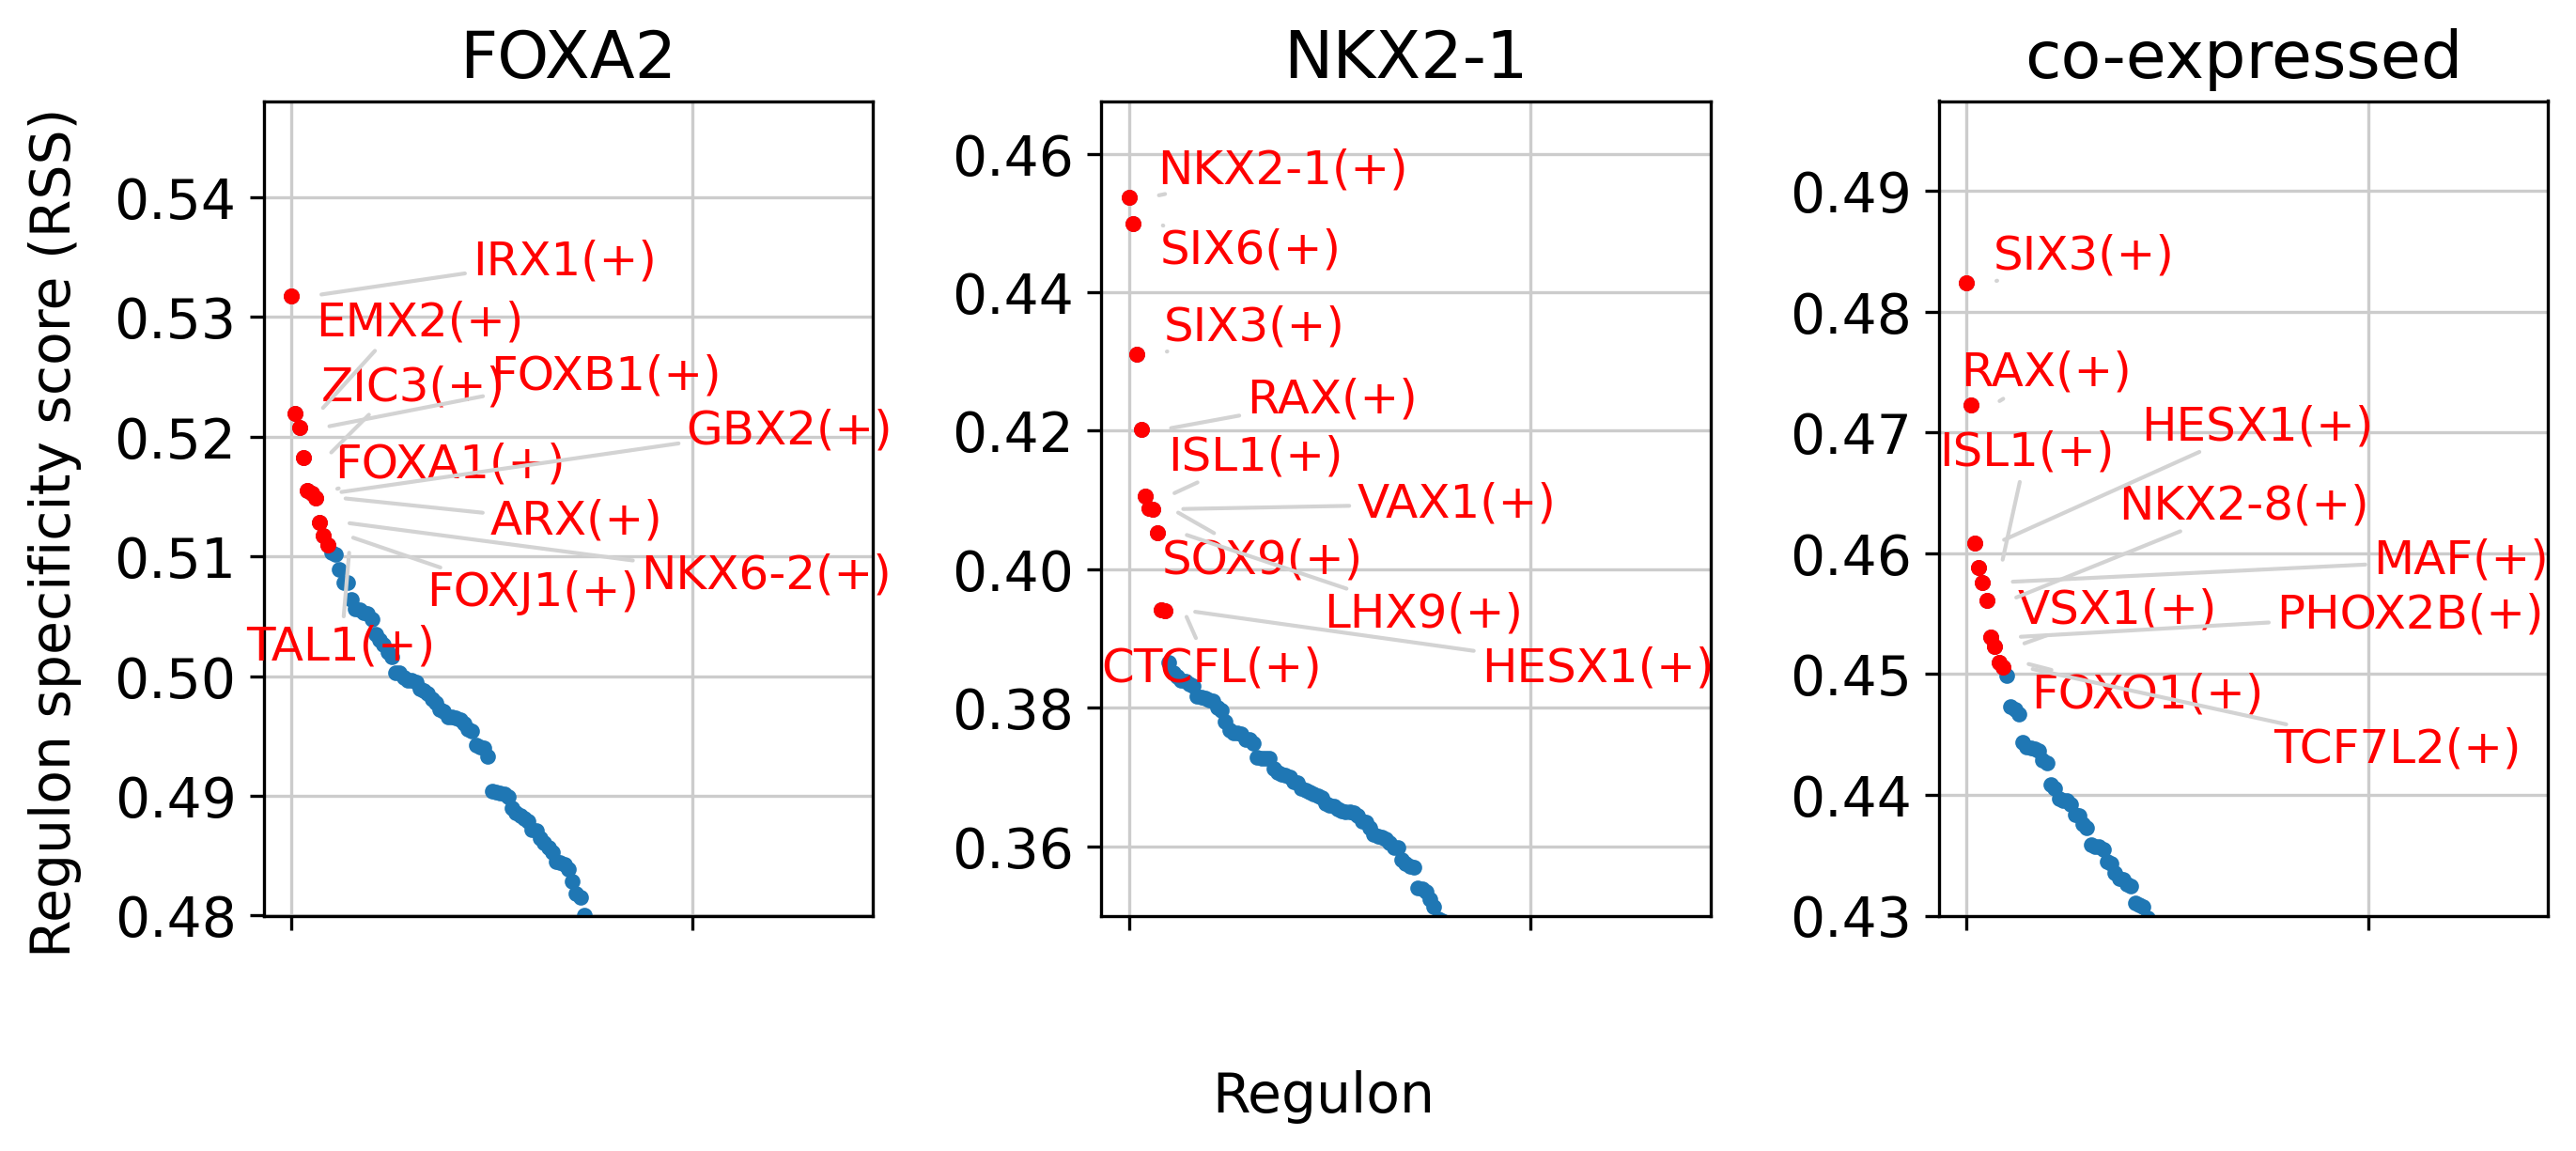

In [40]:
cats = sorted(list(set(adata_scenic.obs.cluster)))

fig = pl.figure(figsize=(15, 10))
ylim_dict = {0: 0.48, 1: 0.35, 2: 0.43}
for c, num in zip(cats, range(1, len(cats) + 1)):
    x = rss_cluster.T[c]
    ax = fig.add_subplot(3, 5, num)
    plot_rss(rss_cluster, c, top_n=10, max_n=None, ax=ax)
    ax.set_ylim(ylim_dict[cats.index(c)], x.max() + (x.max() - x.min()) * 0.05)
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'))

fig.text(0.3, 0.6, 'Regulon', ha='center', va='center', size='medium')
fig.text(0.00, 0.8, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='medium')
pl.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
    'figure.titlesize': 'medium',
    'axes.labelsize': 'large',
    'axes.titlesize': 'large',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'medium'
})
plt.pyplot.savefig("ventral_d5_9_14_NKX2-1_FOXA2_OTX2_clusters-RSS-top10.svg", dpi=50, bbox_inches="tight")
pl.show()



In [66]:
#### save scenic adata###

#adata_scenic.write('adata_scenic_grn_NKX_foxa2.h5ad')